In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import sys

from gaussian_env import GaussianEnv, GaussianEnv_1_cond
from diffusion_opt import Diffsion

In [2]:
x_dim = 2
y_dim = 2
env = GaussianEnv_1_cond(x_dim=x_dim, y_dim=y_dim)

In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

diffusion_timesteps = 1000
diffusion = Diffsion(x_dim=x_dim, y_dim=y_dim, timesteps=diffusion_timesteps, beta_schedule="linear", device=device)
optimizer = optim.Adam(diffusion.model_net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [4]:
num_epochs = 1000
batch_size = 2000

s_batch = np.random.uniform(-1,1,(batch_size, x_dim))
x0_batch = env.sample(s_batch)

s_t = torch.tensor(s_batch, dtype=torch.float32, device=device)
x0_t = torch.tensor(x0_batch, dtype=torch.float32, device=device)

In [5]:
for epoch in range(num_epochs):    
    t = torch.randint(0, diffusion_timesteps, (batch_size,), device=device).long()
    loss = diffusion.diffusion_loss(x0_t, t, s_t)
    optimizer.zero_grad(); loss.backward(); optimizer.step()

    if (epoch+1) % 1000==0:
            print(f"Epoch {epoch+1}, Loss={loss:.4f}")

Epoch 1000, Loss=0.3782


In [6]:
batch_size = batch_size
diffusion.model_net.eval()
for step in range(100):
    t_eval = torch.randint(1, diffusion.timesteps, (batch_size,), device=device, dtype=torch.long)
    gaussian_noise = torch.randn_like(x0_t).float()
    # Forward: x_t ~ q(x_t | x_0)
    x_noisy = diffusion.q_sample(x0_t, t_eval, noise=gaussian_noise)
    # Reverse: train the noise predicition model condition on s and a
    predicted_noise = diffusion.model_net(x_noisy, t_eval, s_t)
    loss = F.mse_loss(gaussian_noise, predicted_noise)
    print(f"step={step + 1}, loss = {loss: .4f}")

step=1, loss =  0.3807
step=2, loss =  0.3527
step=3, loss =  0.3592
step=4, loss =  0.3468
step=5, loss =  0.3620
step=6, loss =  0.3717
step=7, loss =  0.3800
step=8, loss =  0.3649
step=9, loss =  0.3816
step=10, loss =  0.3693
step=11, loss =  0.3690
step=12, loss =  0.3658
step=13, loss =  0.3699
step=14, loss =  0.3589
step=15, loss =  0.3893
step=16, loss =  0.3742
step=17, loss =  0.3695
step=18, loss =  0.3666
step=19, loss =  0.3657
step=20, loss =  0.3943
step=21, loss =  0.3830
step=22, loss =  0.3652
step=23, loss =  0.3856
step=24, loss =  0.3736
step=25, loss =  0.3772
step=26, loss =  0.3623
step=27, loss =  0.3790
step=28, loss =  0.3686
step=29, loss =  0.3637
step=30, loss =  0.3785
step=31, loss =  0.3537
step=32, loss =  0.3585
step=33, loss =  0.4158
step=34, loss =  0.3809
step=35, loss =  0.3782
step=36, loss =  0.3736
step=37, loss =  0.3905
step=38, loss =  0.3774
step=39, loss =  0.3596
step=40, loss =  0.3844
step=41, loss =  0.3788
step=42, loss =  0.3812
s

In [7]:
import os
ckpt_dir = "./checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

data_file = os.path.join(ckpt_dir, "train_data.npz")
model_ckpt = os.path.join(ckpt_dir, "diffusion.pt")

np.savez_compressed(
    data_file,
    s_batch=s_batch.astype(np.float32),
    x0_batch=x0_batch.astype(np.float32)
)
torch.save(
    {
        "model_state_dict": diffusion.model_net.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    },
    model_ckpt
)
print(f"Saved arrays → {data_file}\nSaved model → {model_ckpt}")

Saved arrays → ./checkpoints/train_data.npz
Saved model → ./checkpoints/diffusion.pt


In [8]:
import os
def load_dataset_and_model(diffusion, optimizer):
    ckpt_dir = "./checkpoints"

    data_file = os.path.join(ckpt_dir, "train_data.npz")
    model_ckpt = os.path.join(ckpt_dir, "diffusion.pt")

    np_data = np.load(data_file)
    s_batch = np_data["s_batch"]
    x0_batch = np_data["x0_batch"]

    ckpt = torch.load(model_ckpt, map_location=device)
    diffusion.model_net.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])

    s_t = torch.from_numpy(s_batch).to(device)
    x0_t = torch.from_numpy(x0_batch).to(device)

    print(f"Loaded arrays from {data_file}")
    print(f"Loaded model from {model_ckpt}")
    return s_batch, x0_batch, s_t, x0_t

s_batch, x0_batch, s_t, x0_t = load_dataset_and_model(diffusion, optimizer)

Loaded arrays from ./checkpoints/train_data.npz
Loaded model from ./checkpoints/diffusion.pt


/tmp/ipykernel_653471/2777738904.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_ckpt, map_location=device)


In [9]:
xs_elbo, true_grad_log = diffusion.sample_elbo(s_t[:100], test_mode=True)
score_elbo, grad_x0 = diffusion.compute_elbo_grad_vec(xs_elbo, s_t[:100])

In [11]:
g_true_x0 = torch.tensor(true_grad_log['A'].clone().detach().cpu())
g_est_x0 = torch.tensor(grad_x0['A'].clone().detach().cpu())

mask = (g_true_x0.norm(dim=1) > 1e-6) & (g_est_x0.norm(dim=1) > 1e-6)

cos_sim_elbo = torch.nn.functional.cosine_similarity(g_true_x0[mask], g_est_x0[mask], dim=1)
cos_sim_elbo

/tmp/ipykernel_653471/2185073370.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g_true_x0 = torch.tensor(true_grad_log['A'].clone().detach().cpu())
/tmp/ipykernel_653471/2185073370.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g_est_x0 = torch.tensor(grad_x0['A'].clone().detach().cpu())


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.9998, 0.9999, 1.0000,
        1.0000, 0.9999, 1.0000, 0.9999, 1.0000, 0.9999, 1.0000, 1.0000, 0.9999,
        1.0000, 0.9999, 0.9998, 0.9998, 0.9999, 1.0000, 1.0000, 0.9999, 0.9999,
        0.9998, 0.9999, 0.9999, 0.9999, 0.9998, 1.0000, 0.9994, 1.0000, 0.9999,
        1.0000, 0.9996, 0.9996, 0.9998, 1.0000, 1.0000, 0.9997, 0.9991, 1.0000,
        0.9998, 0.9999, 0.9999, 1.0000, 0.9996, 0.9992, 0.9997, 0.9997, 0.9997,
        1.0000, 0.9999, 0.9999, 0.9998, 0.9999, 0.9987, 0.9998, 0.9996, 0.9995,
        0.9996, 0.9996, 0.9989, 0.9991, 

cos_sim_elbo_np.mean():  0.8183352


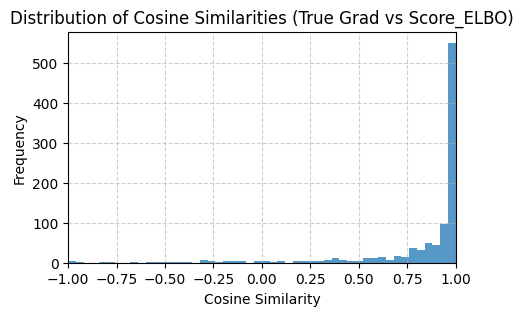

In [21]:
# cos_sim_elbo = torch.nn.functional.cosine_similarity(torch.tensor(true_grad_log['A'].clone().detach().cpu()), torch.tensor(grad_x0[0].clone().detach().cpu()))
import matplotlib.pyplot as plt

# cos_sim_elbo_np = abs(cos_sim_elbo.cpu().detach().numpy())
cos_sim_elbo_np = cos_sim_elbo.cpu().detach().numpy()

print("cos_sim_elbo_np.mean(): ", cos_sim_elbo_np.mean())

plt.figure(figsize=(5, 3))
plt.hist(cos_sim_elbo_np, bins=50, alpha=0.75)
plt.title('Distribution of Cosine Similarities (True Grad vs Score_ELBO)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.xlim(-1, 1.0001)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
g_true_x0 = torch.tensor(true_grad_log['B'].clone().detach().cpu())
g_est_x0 = torch.tensor(grad_x0['B'].clone().detach().cpu())

mask = (g_true_x0.norm(dim=1) > 1e-10) & (g_est_x0.norm(dim=1) > 1e-10)

cos_sim_elbo = torch.nn.functional.cosine_similarity(g_true_x0[mask], g_est_x0[mask], dim=1)

/tmp/ipykernel_653471/1282394117.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g_true_x0 = torch.tensor(true_grad_log['B'].clone().detach().cpu())
/tmp/ipykernel_653471/1282394117.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g_est_x0 = torch.tensor(grad_x0['B'].clone().detach().cpu())


cos_sim_elbo_np.mean():  0.96327853


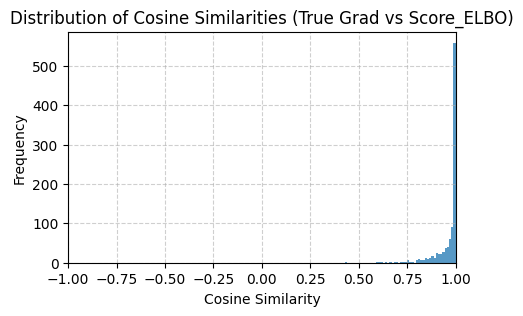

In [15]:
# cos_sim_elbo = torch.nn.functional.cosine_similarity(torch.tensor(true_grad_log['A'].clone().detach().cpu()), torch.tensor(grad_x0[0].clone().detach().cpu()))
import matplotlib.pyplot as plt

# cos_sim_elbo_np = abs(cos_sim_elbo.cpu().detach().numpy())
cos_sim_elbo_np = cos_sim_elbo.cpu().detach().numpy()

print("cos_sim_elbo_np.mean(): ", cos_sim_elbo_np.mean())

plt.figure(figsize=(5, 3))
plt.hist(cos_sim_elbo_np, bins=50, alpha=0.75)
plt.title('Distribution of Cosine Similarities (True Grad vs Score_ELBO)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [16]:
g_true_x0 = torch.tensor(true_grad_log['c'].clone().detach().cpu())
g_est_x0 = torch.tensor(grad_x0['c'].clone().detach().cpu())

mask = (g_true_x0.norm(dim=1) > 1e-10) & (g_est_x0.norm(dim=1) > 1e-10)

cos_sim_elbo = torch.nn.functional.cosine_similarity(g_true_x0[mask], g_est_x0[mask], dim=1)

/tmp/ipykernel_653471/1634636457.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g_true_x0 = torch.tensor(true_grad_log['c'].clone().detach().cpu())
/tmp/ipykernel_653471/1634636457.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g_est_x0 = torch.tensor(grad_x0['c'].clone().detach().cpu())


cos_sim_elbo_np.mean():  0.8183352


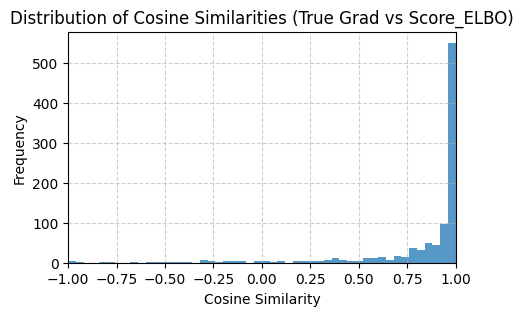

In [17]:
# cos_sim_elbo = torch.nn.functional.cosine_similarity(torch.tensor(true_grad_log['A'].clone().detach().cpu()), torch.tensor(grad_x0[0].clone().detach().cpu()))
import matplotlib.pyplot as plt

# cos_sim_elbo_np = abs(cos_sim_elbo.cpu().detach().numpy())
cos_sim_elbo_np = cos_sim_elbo.cpu().detach().numpy()

print("cos_sim_elbo_np.mean(): ", cos_sim_elbo_np.mean())

plt.figure(figsize=(5, 3))
plt.hist(cos_sim_elbo_np, bins=50, alpha=0.75)
plt.title('Distribution of Cosine Similarities (True Grad vs Score_ELBO)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# TODO: compute gradient norm difference
# ------------------------------old score-matching--------------------------------

In [ ]:
true_grad_data = env.grad_log_prob(s_batch, x0_batch)
xs, score = diffusion.sample(s_t[:1000], test_mode=True)
true_grad = env.grad_log_prob(s_batch[:1000], xs.cpu().detach().numpy())

In [ ]:
cos_sim = torch.nn.functional.cosine_similarity(torch.tensor(true_grad), torch.tensor(score.cpu().detach().numpy()), dim=1)
# cos_sim_gt = torch.nn.functional.cosine_similarity(torch.tensor(true_grad_data), torch.tensor(score.cpu().detach().numpy()), dim=1)

import matplotlib.pyplot as plt

cos_sim = cos_sim.cpu().detach().numpy()
# cos_sim_gt = cos_sim_gt.cpu().detach().numpy()

print(f"cos_sim.mean(): {cos_sim.mean():.4f}")

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].hist(cos_sim, bins=50, alpha=0.75)
axs[0].set_title('True Score vs Score')
axs[0].set_xlabel('Cosine Similarity')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(-1, 1)
axs[0].grid(True, linestyle='--', alpha=0.6)

# axs[1].hist(cos_sim_gt, bins=50, alpha=0.75)
# axs[1].set_title('True Grad of Data vs Score')
# axs[1].set_xlabel('Cosine Similarity')
# axs[1].set_ylabel('Frequency')
# axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()